In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, ttest_ind, anderson_ksamp
%matplotlib inline

In [2]:
np.random.seed(0)

In [3]:
N = 30000
M = 3000
scale_1 = 14.4
scale_2 = 10
x_train = np.random.normal(loc=500, scale=scale_1, size=N)

x_new_1 = np.random.normal(loc=490, scale=scale_2, size=int(M/2))
x_new_2 = np.random.normal(loc=510, scale=scale_2, size=int(M/2))
x_new = np.concatenate((x_new_1,x_new_2))

In [4]:
print(x_train[:5])
print(x_new[:5])

[525.40235378 505.7622638  514.09382697 532.26886207 526.89283506]
[493.71232144 493.04783891 495.04124602 491.35299604 496.5375878 ]


In [5]:
print(x_train.mean(), x_train.std())
print(x_new.mean(), x_new.std())

499.9370789319391 14.29489720125223
499.99017939635786 14.299418992619533


In [6]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [10, 7]

/Users/akim/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


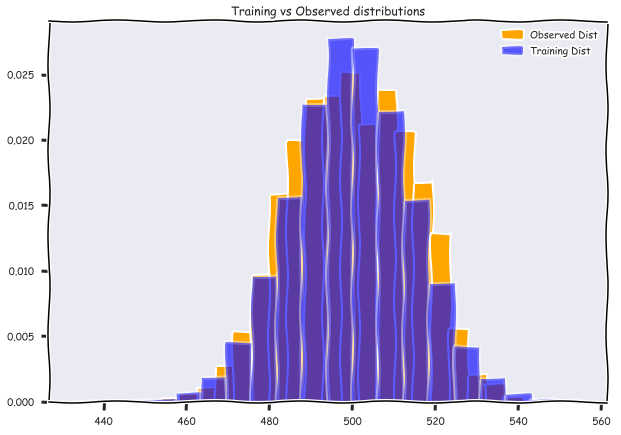

In [7]:
with plt.xkcd():
    plt.hist(x_new, bins=20, color='orange', label="Observed Dist", normed=True)
    plt.hist(x_train, bins=20, alpha = 0.4, color='blue', label="Training Dist", normed=True)
    plt.title('Training vs Observed distributions')
    plt.legend()

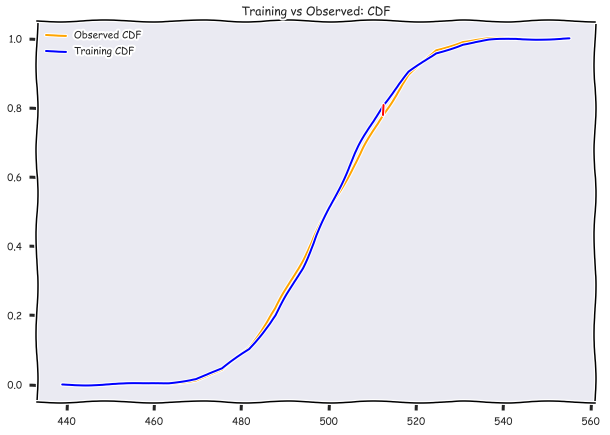

In [8]:
x_train_hist, x_train_bins = np.histogram(x_train, bins=20)
x_new_hist, _ = np.histogram(x_new, bins=x_train_bins)
x_train_cdf = np.cumsum(x_train_hist/len(x_train))
x_new_cdf = np.cumsum(x_new_hist/len(x_new))
idx = np.argmax(np.abs(x_train_cdf-x_new_cdf))
ks_x = (x_train_bins[idx+2], x_train_bins[idx+2])
ks_y = (x_new_cdf[1:][idx], x_train_cdf[1:][idx])
with plt.xkcd():
    plt.plot(x_train_bins[1:], x_new_cdf, color='orange', label="Observed CDF")
    plt.plot(x_train_bins[1:], x_train_cdf, color='b', label="Training CDF")
    plt.plot(ks_x, ks_y, color='r')
    plt.title('Training vs Observed: CDF')
    plt.legend()

In [9]:
n_buckets = 21
bins = np.linspace(start=1.01*max(min(x_train),min(x_new)), stop=0.99*min(max(x_train),max(x_new)), num=n_buckets)
x_new_hist = np.histogram(x_new, bins=bins)[0]/len(x_new)
x_train_hist  = np.histogram(x_train, bins=bins)[0]/len(x_train)
psi = np.sum((x_train_hist - x_new_hist)*np.log(x_train_hist/x_new_hist))

In [10]:
df = pd.DataFrame({'bin_edges': bins[1:], 
                       'training count': np.histogram(x_train, bins=bins)[0],
                       'observed count': np.histogram(x_new, bins=bins)[0],
                       'training percent': np.histogram(x_train, bins=bins)[0]/len(x_train),
                       'observed percent': np.histogram(x_new, bins=bins)[0]/len(x_new),
                       'psi': (x_train_hist - x_new_hist)*np.log(x_train_hist/x_new_hist)
                      })

In [11]:
df.head()

,bin_edges,training count,observed count,training percent,observed percent,psi
0,462.570797,74,7,0.002467,0.002333,0.000007
1,466.410157,159,11,0.005300,0.003667,0.000602
2,470.249517,288,28,0.009600,0.009333,0.000008
3,474.088877,463,44,0.015433,0.014667,0.000039
4,477.928237,835,80,0.027833,0.026667,0.000050


In [12]:
df['psi'].sum()

0.021066222095270176

In [13]:
def psi(x_train, x_new, n_buckets=20):
    bins = np.linspace(start=1.01*max(min(x_train),min(x_new)), stop=0.99*min(max(x_train),max(x_new)), num=n_buckets)
    x_new_hist = np.histogram(x_new, bins=bins)[0]/len(x_new)
    x_train_hist  = np.histogram(x_train, bins=bins)[0]/len(x_train)
    psi = np.sum((x_train_hist - x_new_hist)*np.log(x_train_hist/x_new_hist))
    return psi

def print_stats(x_train, x_new):
    print(f'KS-test p-value: {ks_2samp(x_train, x_new).pvalue:.3f}')
    print(f'T-test p-value:  {ttest_ind(x_train, x_new).pvalue:.3f}')
    print(f'PSI:             {psi(x_train, x_new):.3f}')

In [14]:
print_stats(x_train, x_new)

KS-test p-value: 0.004
T-test p-value:  0.846
PSI:             0.023


In [15]:
n_weeks = 52
weeks = np.arange(1, n_weeks + 1)
c = np.linspace(1.0, 0.999, n_weeks)
ks_lst = []
mean_lst = []
for ii in range(n_weeks):
    x_sample = x_train*c[ii] + np.random.uniform(low=-0.03, high=0.03)
    ks_pvalue = ks_2samp(x_train, x_sample).pvalue
    ks_lst.append(ks_pvalue)
    mean_lst.append(x_sample.mean())

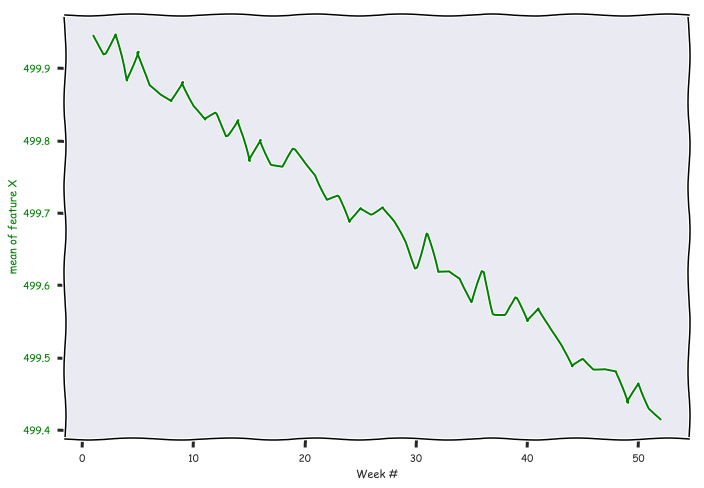

In [24]:
with plt.xkcd():
    fig, ax1 = plt.subplots()
    color = 'tab:blue'
    ax1.set_xlabel('Week #')
    ax1.set_ylabel('mean of feature X', color='g')
    ax1.plot(weeks, mean_lst, color='g')
    ax1.tick_params(axis='y', labelcolor='g')
    fig.tight_layout()

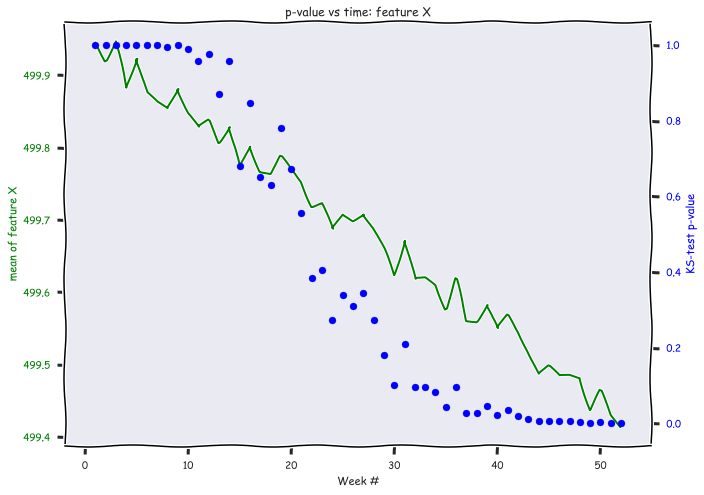

In [22]:
with plt.xkcd():
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Week #')
    ax1.set_ylabel('mean of feature X', color='g')
    ax1.plot(weeks, mean_lst, color='g')
    ax1.tick_params(axis='y', labelcolor='g')
    ax2 = ax1.twinx()
    ax2.set_ylabel('KS-test p-value', color='b')
    ax2.scatter(weeks, ks_lst, color='b')
    #ax2.axhline(y=0.9, color='r', linestyle='-')
    ax2.tick_params(axis='y', labelcolor='b')
    fig.tight_layout()
    plt.title('p-value vs time: feature X')

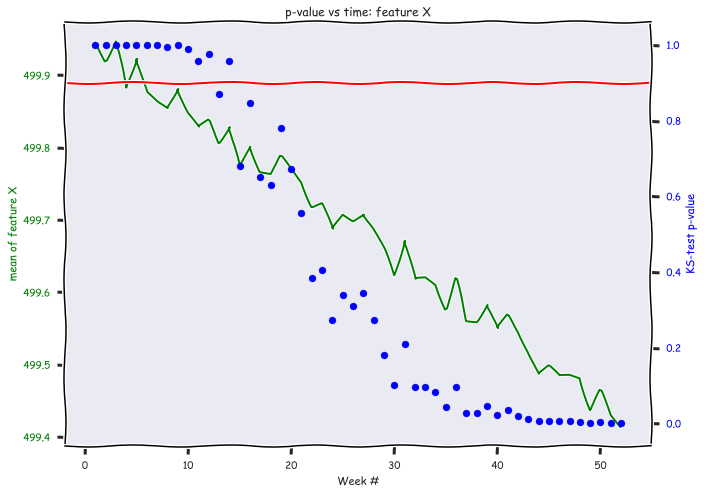

In [23]:
with plt.xkcd():
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Week #')
    ax1.set_ylabel('mean of feature X', color='g')
    ax1.plot(weeks, mean_lst, color='g')
    ax1.tick_params(axis='y', labelcolor='g')
    ax2 = ax1.twinx()
    ax2.set_ylabel('KS-test p-value', color='b')
    ax2.scatter(weeks, ks_lst, color='b')
    ax2.axhline(y=0.9, color='r', linestyle='-')
    ax2.tick_params(axis='y', labelcolor='b')
    fig.tight_layout()
    plt.title('p-value vs time: feature X')